In [ ]:
# Connecting colab to the drive
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import seaborn

In [ ]:
# Some parameters initialized to be used for text preparation

DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 50
W2V_MIN_COUNT = 2
SEQUENCE_LENGTH = 300

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# read csv file
df = pd.read_csv(r"./drive/My Drive/code/Amazon_Electronics.csv")
df.head()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


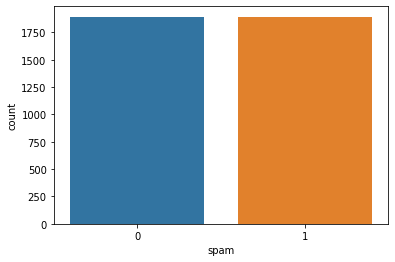

In [ ]:
seaborn.countplot(dfs['label'])

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
dfs['reviews.text'] = dfs['reviews.text'].apply(lambda x: preprocess(x))

In [ ]:
dfs['reviews.text']

In [ ]:
# split data into train/test
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(dfs['reviews.text'],dfs['spam'], test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
print("TRAIN size:", len(y_train))
print("TEST size:", len(y_test))


TRAIN size: 3028
TEST size: 758
TRAIN size: 3028
TEST size: 758


In [ ]:
documents = [_text.split() for _text in df_train]
w2v = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
w2v.build_vocab(documents)
words = w2v.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 4745


In [ ]:
words

dict_keys(['works', 'great', 'need', 'wish', 'power', 'switch', 'return', 'one', 'defective', 'stick', 'good', 'looking', 'memory', 'though', 'relatively', 'well', 'picture', 'almost', 'directly', 'viewing', 'cable', 'set', 'somewhat', 'difficult', 'required', 'two', 'phone', 'calls', 'tech', 'support', 'upgraded', 'last', 'model', 'longer', 'long', 'router', 'since', 'wi', 'fi', 'heavy', 'duty', 'sure', 'find', 'wall', 'studs', 'put', 'older', 'flat', 'screen', 'extremely', 'probably', 'weight', 'limit', 'holds', 'wonderfully', 'adjust', 'tv', 'tilting', 'clear', 'plenty', 'floor', 'space', 'move', 'things', 'way', 'lots', 'screws', 'bolts', 'tools', 'want', 'get', 'lay', 'everything', 'see', 'also', 'like', 'tape', 'measure', 'stud', 'finder', 'various', 'types', 'sizes', 'points', 'person', 'job', 'held', 'husband', 'screw', 'holes', 'make', 'tip', 'better', 'safe', 'sorry', 'suppose', 'super', 'slim', 'description', 'motion', 'tight', 'moving', 'left', 'right', 'smooth', 'hoped', '

In [ ]:
w2v.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(4417066, 4940800)

In [ ]:
w2v.wv.most_similar("crew")

In [ ]:
# SAVING EMBEDDING MATRIX AND CLEANED TRAIN AND TEST DATASET CSV FILE
w2v.wv.save_word2vec_format('./drive/My Drive/code/embeddings_with_stopwords.txt', binary=False)
df_train.to_csv('./drive/My Drive/code/new_data_with_trainset.csv', index=False)
df_test.to_csv('./drive/My Drive/code/new_data_with_testset.csv', index=False)

In [ ]:
# Tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 8319


In [ ]:
import pickle
# Saving the tokenzer file to be used at test time
with open('./w2v_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/My Drive/DL_Project/notebookks/basit/w2v_tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [ ]:
# Padding the embedding with zero for making them of same length
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test), maxlen=SEQUENCE_LENGTH)

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3028, 6166)
y_train (3028,)

x_test (758, 6166)
y_test (758,)


In [ ]:
# Getting embedding matrix which will be used in training in embedding layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v.wv:
    embedding_matrix[i] = w2v.wv[word]
print(embedding_matrix.shape)

(8319, 6166)


In [ ]:
# SAVING DATA IN NPZ FILES
np.savez('./drive/My Drive/code/embedding_matrix', embedding_matrix)
np.savez('./drive/My Drive/code/trainset', x_train, y_train, allow_pickle=True)
np.savez('./drive/My Drive/code/testset', x_test, y_test, allow_pickle=True)